# Custom Objective and Evaluation Functions

This demo was adapted from **[xgboost's custom metric tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html)**.  We take a number of functions, 3 of which are developed here on the notebook, while others are already available in the functions markteplace, and demonstrate how to use a custom objective and a custom evaluation function using an xgboost trainer.  This could be replicated for other models that permit customizing functions.

**Advanced Deprecation Warning**: Once debugged, it is our intention to refactor the cutom features option from `xgb_trainer_custom` into the existing marketplace function `xgb_trainer` .

## project functions

* [x] **xgb_datagen** (adapted from xgboost tutorial)  
   * this could be replaced with data from `load_data` or `arc_to_parquet`...  
* [x] describe (available in functions marketplace)  
* [x] **xgb_trainer_custom** (with custom objective and evaluation)  
* [ ] **xgb_test_custom**  (with custom objective and evaluation)  
* [x] xgb_serving  (available in functions marketplace)  

### generate data

This function simply generates some data we can use to train and test using a custom objective.

In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [3]:
from os import path
import numpy as np
from numpy.random import randint, randn, seed
import pandas as pd
from xgboost import DMatrix, train
import matplotlib.pyplot as plt
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact
from mlutils import get_splits
from typing import Tuple, Dict, List

In [4]:
seed(seed=1994)

In [5]:
def xgb_datagen(
    context,
    n_rows: int = 4_096,
    m_features: int = 16,
    o_max: int = 10_000,
    o_outs = 64,
    test_size: float = 0.05,
    valid_size: float = 0.75,
    silent: bool = True,
    data_dest: str = "datagen",
    file_ext = "bin",
    random_state = 1994
) -> Tuple[DMatrix, DMatrix]:
    """generate data containing outliers
    
    to replicate results from the origin xgboost demo, use this function
    with it's default values.
    
    In an effort to improve performance we are saving our data artifacts using XGBoost's
    internal binary format as xgboost.DMatrices. This is the data format employed internally 
    by xgboost.
    
    :param context:       mlrun function context
    :param n_rows:        (4_096) number of generated rows
    :param m_features:    (16) number of features
    :param o_max:         (10_000) max value    
    :param o_outs:        (64) total number of outliers
    :param test_size:     (0.05) test set proportion of toal obs
    :param valid_size:    (0.25) valid set proportion (after test removed, valid set
                          under the default would be 0.25*(1-0.05) = 0.2375)
    :param silent:        (True) verbose output
    :param data_dest:     (datagen) subfolder
    :param file_ext:      (bin) DMatrix file format is binary.  Note that a DMatrix can 
                          be loaded into dask
    :param random_state:  numpy/sklearn RNG seed
    """
    x = randn(n_rows, m_features)
    y = randn(n_rows)
    y += np.abs(np.min(y))

    # Create outliers
    for i in range(0, o_outs):
        ind = randint(0, len(y)-1)
        y[ind] += randint(0, o_max)

    # rmsle requires all label be greater than -1.
    assert np.all(y > -1.0)

    splits = get_splits(x, y, 3, test_size, valid_size, random_state)
    
    keys = ["dtrain", "dvalid", "dtest"]
    
    for k,v in dict(zip(keys, splits)).items():
        local = f"{k}.bin"
        fullname = path.join(context.artifact_path, local)
        DMatrix(v[0], label=v[1]).save_binary(fullname, silent=silent)
        # as an experiment, and as part ofa larger analysis, this should be logged):
        context.log_artifact(path.splitext(local)[0], local_path=local)

## define some custom functions

In [6]:
def _gradient(predt: np.ndarray, dtrain: DMatrix) -> np.ndarray:
    """Compute the gradient squared log error."""
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def _hessian(predt: np.ndarray, dtrain: DMatrix) -> np.ndarray:
    """Compute the hessian for squared log error."""
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def _squared_log(predt: np.ndarray,
                dtrain: DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    """Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    """
    predt[predt < -1] = -1 + 1e-6
    grad = _gradient(predt, dtrain)
    hess = _hessian(predt, dtrain)
    return grad, hess

def _rmsle(predt: np.ndarray, dtrain: DMatrix) -> Tuple[str, float]:
    """ Root mean squared log error metric.
    """
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return "my_rmsle", float(np.sqrt(np.sum(elements) / len(y)))

def _check_functions(obj_eval, splitter=":"):
    """check object and eval function consistency
    
    need a check that functions pairings are consistent, etc...
    
    """
    if isintance(obj_eval, string):
        # do some checks here:
        obj_func, eval_func = obj_eval.split(splitter)
        # if pass
        return obj_func, eval_func
    else:
        raise Exception("inconsistent objective:eval pair")

## define an xgboost train function handler

In [7]:
def xgb_trainer_custom(
    context: MLClientCtx,
    dtrain: DataItem,
    dtest: DataItem,
    tree_method: str = "hist",
    random_state: int = 1994,
    num_boost_round: int = 60,
    models_dest: str = "models",
    plots_dest: str = "plots",
    file_ext: str = "parquet",
) -> None:
    """train an xgboost model with a custom objective function
    
    Uses xgboost.DMatrix for performance improvement. Exposes only 
    a couple of parameters, for demo only. This function will likely
    be refactored into the existing `xgb_trainer`.
    
    :param obj_eval:  either a native string "reg:squaredlogerror"
                      or array of functions
    """
            
    dtrain = DMatrix(str(dtrain))
    dtest = DMatrix(str(dtest))

    def _learning_curves(results: dict = {}):
        native = results["native"]
        custom = results["custom"]
        
        fig, axs = plt.subplots(2, 1)
        ax0: matplotlib.axes.Axes = axs[0]
        ax1: matplotlib.axes.Axes = axs[1]

        x = np.arange(0, 3, 1)
        
        key = list(native["dtrain"].keys())[0]
        ax0.plot(x, native["dtrain"][key], label="train-native-rmsle")
        ax0.plot(x, native["dtest"][key], label="test-native-rmsle")
        ax0.legend()

        key = list(custom["dtrain"].keys())[0]
        ax1.plot(x, custom["dtrain"][key], label="train-custom-rmsle")
        ax1.plot(x, custom["dtest"][key], label="test-custom-rmsle")
        ax1.legend()
        
        context.log_artifact(PlotArtifact("learning-curves", body=plt.gcf()), 
                             local_path="plots/learning-curves.html")

    def _train(an_obj_func, an_eval_func, is_custom):
        """internal training 
        """
        results: Dict[str, Dict[str, List[float]]] = {}
        
        params = {
            "tree_method": tree_method, 
            "seed": random_state,
            "disable_default_eval_metric": 1 if is_custom else 0,
            # if native == True, then set these parameters
            "objective" : an_obj_func if not is_custom else None,
            "eval_metric" :  an_eval_func if not is_custom else None}

        train(params,
            # if custom == True, then set these parameters:
            obj=an_obj_func if is_custom else None,
            feval=an_eval_func if is_custom else None,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dtrain, "dtrain"), (dtest, "dtest")],
            evals_result=results,
            verbose_eval=False)

        return results
 
    def _log_results(results:dict):
        pass
 
    results_custom = _train(_squared_log, _rmsle, True)
    results_native = _train("reg:squaredlogerror", 'rmsle', False)

    _log_results({"custom":results_custom, "native":results_native})
    _learning_curves({"custom":results_custom, "native":results_native})

In [8]:
# nuclio: end-code

## local imports to generate project, run tests locally and remotely

In [9]:
from os import path, environ, makedirs
from mlrun import (mlconf, new_project, 
                   code_to_function, 
                   NewTask, run_local)
from mlutils import get_vol_mount

## create project and define config

In [10]:
# specify all projects root
projects_root = path.join(environ["HOME"], "projects")

# specify this project's settings
project_name = "my-objectives"
project_dir = path.join(f"{projects_root}/{project_name}")
myobj_proj = new_project(project_name, project_dir, init_git=True)

# artifact_path so we can find our files locally
artifact_path = path.join(mlconf.artifact_path, project_name)
makedirs(artifact_path, exist_ok=True)

In [11]:
# some variables for testing
NROWS = 4096
NFEATS = 16
OMAX = 10_000
TESTSZ = 0.05
VALIDSZ = 0.25

## create 2 functions from notebook code and test locally

### test the data generator

In [12]:
# create data generator function object from notebook code
dgen_fn = code_to_function("xgb_datagen")
# add metadata (for templates and reuse)
dgen_fn.spec.default_handler = "xgb_datagen"
dgen_fn.spec.description = "generate xgboost data for demos and tests"
dgen_fn.metadata.categories = ["simulation", "ml"]
dgen_fn.metadata.labels = {"author": "yjb", "framework": "xgboost"}

# mount volume into function container
dgen_fn.apply(get_vol_mount())

# dgen_fn.export("function.yaml")

task_params = {
    "name" : "tasks xgb data generator",
    "params" : {
        "n_rows"    : NROWS,
        "n_feature" : NFEATS,
        "o_max"     : OMAX}}

task = NewTask(**task_params)

run_dgen = run_local(task, handler=xgb_datagen, artifact_path=artifact_path)

print(run_dgen.outputs)

### using run outputs test using default values

from xgboost import DMatrix
dvalid = DMatrix(run_dgen.outputs["dvalid"])
dtrain = DMatrix(run_dgen.outputs["dtrain"])
dtest = DMatrix(run_dgen.outputs["dtest"])

assert dtest.num_row() ==  np.int(np.round(NROWS*TESTSZ)) # test is taken out first
# # then train/valid split
assert dvalid.num_row() == int(np.round((NROWS*(1-TESTSZ))*VALIDSZ))
assert dtrain.num_row() == int(np.round((NROWS*(1-TESTSZ))*(1-VALIDSZ)))

[mlrun] 2020-05-24 03:30:10,110 starting run tasks xgb data generator uid=8eeee3017ae343ad8c350b16154a325f  -> http://mlrun-api:8080
[mlrun] 2020-05-24 03:30:10,170 log artifact dtrain at /User/artifacts/my-objectives/dtrain.bin, size: None, db: Y
[mlrun] 2020-05-24 03:30:10,184 log artifact dvalid at /User/artifacts/my-objectives/dvalid.bin, size: None, db: Y
[mlrun] 2020-05-24 03:30:10,201 log artifact dtest at /User/artifacts/my-objectives/dtest.bin, size: None, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...154a325f,0,May 24 03:30:10,completed,tasks xgb data generator,v3io_user=adminkind=handlerowner=adminhost=jupyter-67c88b95d4-crdhq,,n_rows=4096n_feature=16o_max=10000,,dtraindvaliddtest


to track results use .show() or .logs() or in CLI: 
!mlrun get run 8eeee3017ae343ad8c350b16154a325f --project default , !mlrun logs 8eeee3017ae343ad8c350b16154a325f --project default
[mlrun] 2020-05-24 03:30:10,253 run executed, status=completed
{'dtrain': '/User/artifacts/my-objectives/dtrain.bin', 'dvalid': '/User/artifacts/my-objectives/dvalid.bin', 'dtest': '/User/artifacts/my-objectives/dtest.bin'}
[03:30:10] 973x16 matrix with 15568 entries loaded from /User/artifacts/my-objectives/dvalid.bin
[03:30:10] 2918x16 matrix with 46688 entries loaded from /User/artifacts/my-objectives/dtrain.bin
[03:30:10] 205x16 matrix with 3280 entries loaded from /User/artifacts/my-objectives/dtest.bin


### test the learning curves -- should be identical up to eps()

[mlrun] 2020-05-24 03:30:13,458 starting run tasks xgb data generator uid=8a93404e27b9475a90d8703b2fffe1bb  -> http://mlrun-api:8080
[03:30:13] 2918x16 matrix with 46688 entries loaded from /User/artifacts/my-objectives/dtrain.bin
[03:30:13] 973x16 matrix with 15568 entries loaded from /User/artifacts/my-objectives/dvalid.bin
[mlrun] 2020-05-24 03:30:13,864 log artifact learning-curves at /User/artifacts/my-objectives/plots/learning-curves.html, size: 28518, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...2fffe1bb,0,May 24 03:30:13,completed,tasks xgb data generator,v3io_user=adminkind=handlerowner=adminhost=jupyter-67c88b95d4-crdhq,dtraindtest,num_boost_round=3,,learning-curves


to track results use .show() or .logs() or in CLI: 
!mlrun get run 8a93404e27b9475a90d8703b2fffe1bb --project default , !mlrun logs 8a93404e27b9475a90d8703b2fffe1bb --project default
[mlrun] 2020-05-24 03:30:13,897 run executed, status=completed


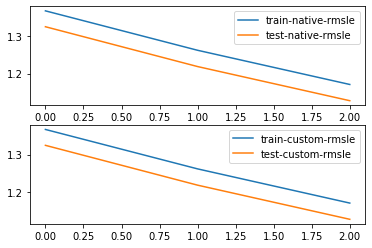

In [13]:
# create a training function object from notebook code
train_fn = code_to_function("train_model_custom")
train_fn.spec.default_handler = "xgb_trainer_custom"
train_fn.spec.description = "train an xgboost model using a custom objective"
train_fn.metadata.categories = ["simulation", "ml"]
train_fn.metadata.labels = {"author": "yjb", "framework": "xgboost"}

# train_fn.export("function.yaml")

# mount volume into function container
train_fn.apply(get_vol_mount())

task_params = {
    "name" : "tasks xgb data generator",
    "params" : {
        "num_boost_round"    : 3}}

task = NewTask(**task_params)

run_train = run_local(task, 
                handler=xgb_trainer_custom,
                inputs={"dtrain": run_dgen.outputs["dtrain"],
                        "dtest" : run_dgen.outputs["dvalid"]},
                artifact_path=artifact_path)

In [14]:
run_train.outputs

{'learning-curves': '/User/artifacts/my-objectives/plots/learning-curves.html'}

### todo - add asserts to test curve identity

## add functions to project

In [16]:
#myobj_proj.set_function("hub://xgb_gendata", "gendata")
myobj_proj.set_function("hub://describe", "describe")
#myobj_proj.set_function("hub://xgb_trainer_custom", "xgbtrainer")
# myobj_proj.set_function("hub://xgb_test_custom", "tester")
myobj_proj.set_function("hub://xgb_serving", "server")

## create workflow / pipeline

## query mlrun db for run results